# Trabalhando com dados de Radar do NuScenes

# Setup

In [71]:
# Caminhos
PATH_DATASET_NUSCENES_MINI = '/home/live/Data/nuScenes'

In [72]:
# bibliotecas
import os
import pandas as pd

import argparse
import json
import multiprocessing
import os
import sys
from collections import OrderedDict
from concurrent import futures
from typing import List, Tuple, Union

import cv2
import numpy as np
import tqdm
from PIL import Image
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud
from nuscenes.utils.geometry_utils import view_points
from pyquaternion.quaternion import Quaternion
from shapely.geometry import MultiPoint, box


In [73]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import RadarPointCloud

nusc = NuScenes(version='v1.0-mini', dataroot=PATH_DATASET_NUSCENES_MINI, verbose=True)    #print as informações gerais sobre os dados do meu dataset

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.295 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


# Radar e Camera

## Visualização dos dados do Radar utilizando ferramentas do nuscenes dev toolkit

In [74]:
my_scene = nusc.scene[0]    # seleção de uma Cena
first_sample_token_from_my_scene = my_scene['first_sample_token']   # Seleção do token do primeiro sample
my_sample = nusc.get('sample', first_sample_token_from_my_scene)    # Get do sample, com todos os tokens do sample
sensor1 = 'CAM_FRONT'     # Especificar o sensor
radar_front_data = nusc.get('sample_data', my_sample['data'][sensor1])  # Get dos dados do Sample, (tipo de estrutura, token), Data é um dict
path_to_file_sensor_data = radar_front_data['filename']         # Caminho para o arquivo com os dados do radar
#print(path_to_file_sensor_data)

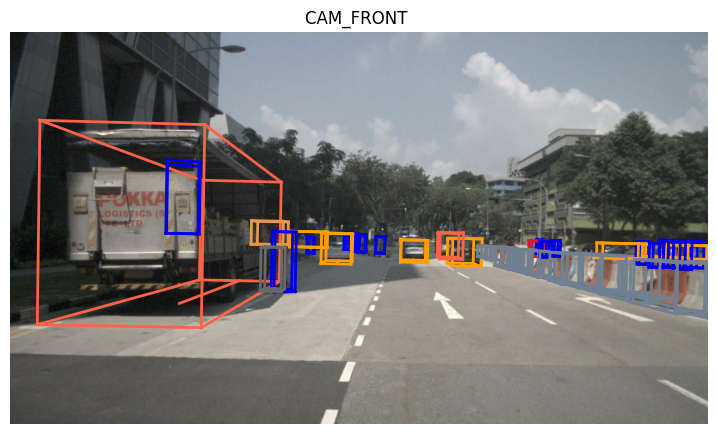

In [75]:
nusc.render_sample_data(radar_front_data['token'])      #renderiza os dados de um sensor a partir do token

In [76]:
my_scene = nusc.scene[0]    # seleção de uma Cena
first_sample_token_from_my_scene = my_scene['first_sample_token']   # Seleção do token do primeiro sample
my_sample = nusc.get('sample', first_sample_token_from_my_scene)    # Get do sample, com todos os tokens do sample
sensor2 = 'RADAR_FRONT'     # Especificar o sensor
radar_front_data = nusc.get('sample_data', my_sample['data'][sensor2])  # Get dos dados do Sample, (tipo de estrutura, token), Data é um dict
path_to_file_sensor_data = radar_front_data['filename']         # Caminho para o arquivo com os dados do radar
#print(path_to_file_sensor_data)

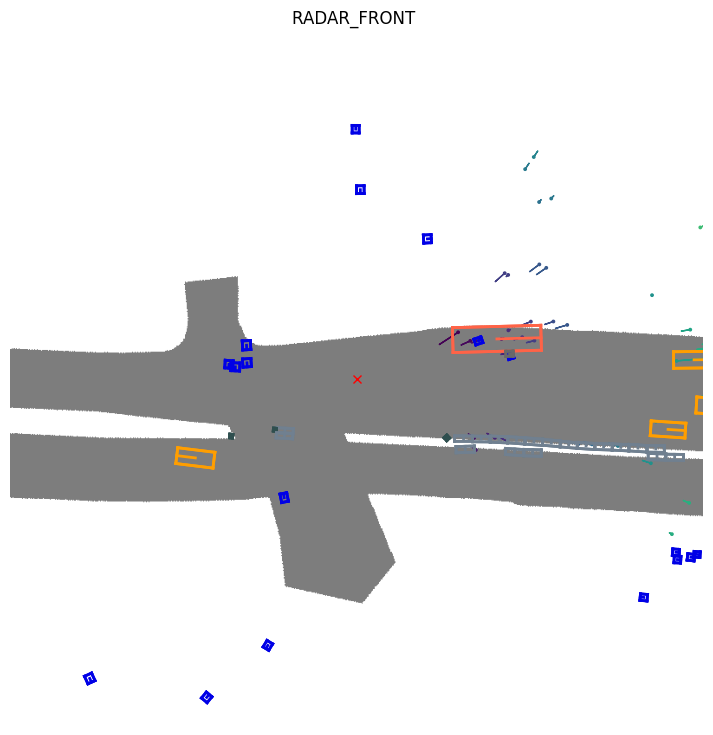

In [77]:
nusc.render_sample_data(radar_front_data['token'])      #renderiza os dados de um sensor a partir do token

## Visualização de dados do radar utilizando ferramentas padrões de rendereização de um arquvio .PCD

PointCloud with 125 points.


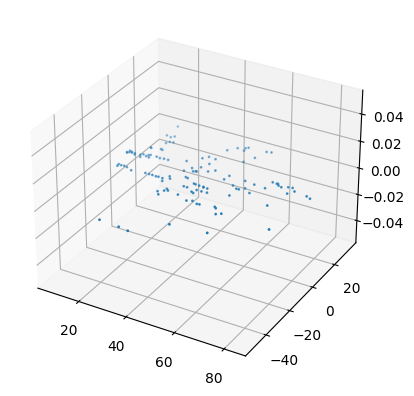

In [78]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Carrega o arquivo .pcd
#arquivo_pcd = '/n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151603555991.pcd'
pcd = o3d.io.read_point_cloud(PATH_DATASET_NUSCENES_MINI + '/'+ path_to_file_sensor_data)
print(pcd)
pontos = np.asarray(pcd.points)

# Visualiza a nuvem de pontos usando Matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pontos[:, 0], pontos[:, 1], pontos[:, 2], s=1)
plt.show()

In [79]:
import plotly.graph_objects as go

# Converte a nuvem de pontos para numpy array
pontos = np.asarray(pcd.points)

# Cria a figura de plotagem usando Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=pontos[:, 0],
    y=pontos[:, 1],
    z=pontos[:, 2],
    mode='markers',
    marker=dict(size=2)
)])

# Configurações da visualização
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z'
))

# Exibe a figura no Jupyter Notebook
fig.show()

## Acessando os dados do radar e camera

In [80]:
my_scene = nusc.scene[2]    # seleção de uma Cena
first_sample_token_from_my_scene = my_scene['first_sample_token']   # Seleção do token do primeiro sample
my_sample = nusc.get('sample', first_sample_token_from_my_scene)    # Get do sample, com todos os tokens do sample
sensor1 = 'CAM_FRONT'     # Especificar o sensor
sensor2 = 'RADAR_FRONT'     # Especificar o sensor
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor1])  # Get dos dados do Sample, (tipo de estrutura, token), Data é um dict CAMERA
radar_front_data = nusc.get('sample_data', my_sample['data'][sensor2])  # Get dos dados do Sample, (tipo de estrutura, token), Data é um dict RADAR
path_to_file_sensor_data = os.path.join(nusc.dataroot, radar_front_data['filename'])    # Caminho para o arquivo com os dados do radar

In [81]:
pc = RadarPointCloud.from_file(path_to_file_sensor_data)        # Ler os dados .pcd e converte em um nd_array
pc = pc.points.T
print(pc.shape)
df_radarPointCould = pd.DataFrame(pc, columns=['x', 'y', 'z', 'dyn_prop', 'id', 'rcs', 'vx', 'vy', 'vx_comp', 'vy_comp', 'is_quality_valid', 'ambig_state', 'x_rms', 'y_rms', 'invalid_state', 'pdh0', 'vx_rms', 'vy_rms'])

(62, 18)


In [82]:
df_radarPointCould.head(10)

,x,y,z,dyn_prop,id,rcs,vx,vy,vx_comp,vy_comp,is_quality_valid,ambig_state,x_rms,y_rms,invalid_state,pdh0,vx_rms,vy_rms
0,6.400000,-3.100000,0.0,1.0,0.0,-3.5,0.0,0.0,0.000633,-0.000306,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
1,8.400000,12.500000,0.0,2.0,1.0,-0.5,-2.0,0.0,-0.622932,-0.926982,1.0,3.0,19.0,19.0,0.0,1.0,18.0,3.0
2,19.799999,-4.500000,0.0,1.0,3.0,-1.0,0.0,0.0,0.000352,-0.000080,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
3,11.400000,-19.299999,0.0,3.0,4.0,18.0,0.0,0.0,0.000701,-0.001187,1.0,3.0,19.0,19.0,0.0,1.0,19.0,3.0
4,21.400000,-9.700000,0.0,1.0,5.0,-2.0,0.0,0.0,0.000607,-0.000275,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
5,16.200001,26.100000,0.0,6.0,6.0,13.0,-6.0,0.0,-1.669383,-2.689562,1.0,3.0,20.0,19.0,0.0,1.0,19.0,3.0
6,28.200001,23.500000,0.0,1.0,8.0,4.0,0.0,0.0,-0.000781,-0.000651,1.0,3.0,19.0,19.0,0.0,1.0,17.0,3.0
7,38.599998,1.100000,0.0,1.0,9.0,12.0,0.0,0.0,-0.000038,-0.000001,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
8,38.599998,-11.100000,0.0,1.0,10.0,6.5,0.0,0.0,0.000431,-0.000124,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
9,23.200001,35.099998,0.0,1.0,11.0,12.0,-1.0,0.0,-0.304780,-0.461111,1.0,3.0,21.0,21.0,0.0,1.0,18.0,3.0


# Posicionar point cloud sensor na imagem

## 01 passo: Transformar para o Referencial do Veículo (Ego Vehicle Frame):

Os dados capturados pelo LiDAR ou radar estão no referencial do próprio sensor. Para combiná-los com outros dados (como os da câmera), precisamos primeiro transformar esses pontos para o referencial do veículo, que é um referencial comum para todos os sensores.

In [83]:
from pyquaternion.quaternion import Quaternion

pc_step_1 = RadarPointCloud.from_file(path_to_file_sensor_data)        # Ler os dados .pcd e converte em um nd_array
cs_record = nusc.get('calibrated_sensor', radar_front_data['calibrated_sensor_token'])      # Token da calibração do sensor, para aquele frame
cs_record

{'token': '002db2f624544e67ac879178fbd5937b',
 'sensor_token': '47fcd48f71d75e0da5c8c1704a9bfe0a',
 'translation': [3.412, 0.0, 0.5],
 'rotation': [0.9999974259839071, 0.0, 0.0, -0.0022689260808398757],
 'camera_intrinsic': []}

In [84]:
pc_step_1.rotate(Quaternion(cs_record['rotation']).rotation_matrix)     # Aplica a rotação
pc_step_1.translate(np.array(cs_record['translation']))         # Aplica a translação

In [85]:
pc_step_1_T = pc_step_1.points.T
df_radarPointCould_1 = pd.DataFrame(pc_step_1_T, columns=['x', 'y', 'z', 'dyn_prop', 'id', 'rcs', 'vx', 'vy', 'vx_comp', 'vy_comp', 'is_quality_valid', 'ambig_state', 'x_rms', 'y_rms', 'invalid_state', 'pdh0', 'vx_rms', 'vy_rms'])
df_radarPointCould_1.head(10)

,x,y,z,dyn_prop,id,rcs,vx,vy,vx_comp,vy_comp,is_quality_valid,ambig_state,x_rms,y_rms,invalid_state,pdh0,vx_rms,vy_rms
0,9.797867,-3.129010,0.5,1.0,0.0,-3.5,0.0,0.0,0.000633,-0.000306,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
1,11.868636,12.461753,0.5,2.0,1.0,-0.5,-2.0,0.0,-0.622932,-0.926982,1.0,3.0,19.0,19.0,0.0,1.0,18.0,3.0
2,23.191375,-4.589803,0.5,1.0,3.0,-1.0,0.0,0.0,0.000352,-0.000080,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
3,14.724302,-19.351532,0.5,3.0,4.0,18.0,0.0,0.0,0.000701,-0.001187,1.0,3.0,19.0,19.0,0.0,1.0,19.0,3.0
4,24.767762,-9.797010,0.5,1.0,5.0,-2.0,0.0,0.0,0.000607,-0.000275,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
5,19.730272,26.026219,0.5,6.0,6.0,13.0,-6.0,0.0,-1.669383,-2.689562,1.0,3.0,20.0,19.0,0.0,1.0,19.0,3.0
6,31.718350,23.371791,0.5,1.0,8.0,4.0,0.0,0.0,-0.000781,-0.000651,1.0,3.0,19.0,19.0,0.0,1.0,17.0,3.0
7,42.016593,0.924828,0.5,1.0,9.0,12.0,0.0,0.0,-0.000038,-0.000001,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
8,41.961231,-11.275047,0.5,1.0,10.0,6.5,0.0,0.0,0.000431,-0.000124,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
9,26.771040,34.994359,0.5,1.0,11.0,12.0,-1.0,0.0,-0.304780,-0.461111,1.0,3.0,21.0,21.0,0.0,1.0,18.0,3.0


## 02 passo: Transformar para o Referencial Global

O veículo não está parado; ele se move no ambiente. Precisamos transformar os pontos para o referencial global (um sistema de coordenadas fixo no mundo) para levar em conta o movimento do veículo.

In [86]:
# Second step: transform to the global frame.
pose_record = nusc.get('ego_pose', radar_front_data['ego_pose_token'])      # ego_pose contem as informações de coordenadas do veiculo em relação as coordeandas globais
print(f"Rotação: {pose_record['rotation']}")
print(f"Translação: {pose_record['translation']}")

Rotação: [0.35587152811800854, 0.0017711875732361756, -0.00898203068595188, 0.9344900435501124]
Translação: [1316.3781761306166, 1038.5936682736387, 0.0]


In [87]:
pc_step_2 = pc_step_1
pc_step_2.rotate(Quaternion(pose_record['rotation']).rotation_matrix)
pc_step_2.translate(np.array(pose_record['translation']))

In [88]:
pc_step_2_T = pc_step_2.points.T
df_radarPointCould_2 = pd.DataFrame(pc_step_2_T, columns=['x', 'y', 'z', 'dyn_prop', 'id', 'rcs', 'vx', 'vy', 'vx_comp', 'vy_comp', 'is_quality_valid', 'ambig_state', 'x_rms', 'y_rms', 'invalid_state', 'pdh0', 'vx_rms', 'vy_rms'])
df_radarPointCould_2.head(10)

,x,y,z,dyn_prop,id,rcs,vx,vy,vx_comp,vy_comp,is_quality_valid,ambig_state,x_rms,y_rms,invalid_state,pdh0,vx_rms,vy_rms
0,1311.141779,1047.437020,0.643570,1.0,0.0,-3.5,0.0,0.0,0.000633,-0.000306,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
1,1299.225351,1037.174979,0.421591,2.0,1.0,-0.5,-2.0,0.0,-0.622932,-0.926982,1.0,3.0,19.0,19.0,0.0,1.0,18.0,3.0
2,1302.112429,1057.435395,0.796211,1.0,3.0,-1.0,0.0,0.0,0.000352,-0.000080,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
3,1318.253575,1062.824434,0.943253,3.0,4.0,18.0,0.0,0.0,0.000701,-0.001187,1.0,3.0,19.0,19.0,0.0,1.0,19.0,3.0
4,1304.398899,1062.371264,0.892357,1.0,5.0,-2.0,0.0,0.0,0.000607,-0.000275,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
5,1284.332646,1032.277090,0.287264,6.0,6.0,13.0,-6.0,0.0,-1.669383,-2.689562,1.0,3.0,20.0,19.0,0.0,1.0,19.0,3.0
6,1277.146682,1042.231842,0.444801,1.0,8.0,4.0,0.0,0.0,-0.000781,-0.000651,1.0,3.0,19.0,19.0,0.0,1.0,17.0,3.0
7,1284.387502,1065.838819,0.893253,1.0,9.0,12.0,0.0,0.0,-0.000038,-0.000001,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
8,1292.543571,1074.909810,1.082138,1.0,10.0,6.5,0.0,0.0,0.000431,-0.000124,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
9,1273.110125,1030.264638,0.216338,1.0,11.0,12.0,-1.0,0.0,-0.304780,-0.461111,1.0,3.0,21.0,21.0,0.0,1.0,18.0,3.0


## 03 Passo: Transformar de Volta para o Referencial do Veículo no Momento da Imagem
A imagem da câmera e os dados do LiDAR ou radar podem ter sido capturados em momentos ligeiramente diferentes. Precisamos ajustar o point cloud para o referencial do veículo no exato momento em que a imagem foi capturada, para garantir que os dados estejam alinhados corretamente.

In [89]:
# Third step: transform into the ego vehicle frame for the timestamp of the image.
pose_record = nusc.get('ego_pose', cam_front_data['ego_pose_token'])
print(f"Rotação: {pose_record['rotation']}")
print(f"Translação: {pose_record['translation']}")

Rotação: [0.3558688047342293, 0.0017714923774391502, -0.008981920282153659, 0.9344910811451506]
Translação: [1316.3781747922362, 1038.5936689044743, 0.0]


In [90]:
pc_step_3 = pc_step_2
pc_step_3.translate(-np.array(pose_record['translation']))
pc_step_3.rotate(Quaternion(pose_record['rotation']).rotation_matrix.T)

In [91]:
pc_step_3_T = pc_step_3.points.T
df_radarPointCould_3 = pd.DataFrame(pc_step_3_T, columns=['x', 'y', 'z', 'dyn_prop', 'id', 'rcs', 'vx', 'vy', 'vx_comp', 'vy_comp', 'is_quality_valid', 'ambig_state', 'x_rms', 'y_rms', 'invalid_state', 'pdh0', 'vx_rms', 'vy_rms'])
df_radarPointCould_3.head(10)

,x,y,z,dyn_prop,id,rcs,vx,vy,vx_comp,vy_comp,is_quality_valid,ambig_state,x_rms,y_rms,invalid_state,pdh0,vx_rms,vy_rms
0,9.797848,-3.129067,0.499996,1.0,0.0,-3.5,0.0,0.0,0.000633,-0.000306,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
1,11.868708,12.461684,0.499988,2.0,1.0,-0.5,-2.0,0.0,-0.622932,-0.926982,1.0,3.0,19.0,19.0,0.0,1.0,18.0,3.0
2,23.191347,-4.589938,0.499990,1.0,3.0,-1.0,0.0,0.0,0.000352,-0.000080,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
3,14.724188,-19.351618,0.500001,3.0,4.0,18.0,0.0,0.0,0.000701,-0.001187,1.0,3.0,19.0,19.0,0.0,1.0,19.0,3.0
4,24.767704,-9.797154,0.499991,1.0,5.0,-2.0,0.0,0.0,0.000607,-0.000275,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
5,19.730422,26.026104,0.499978,6.0,6.0,13.0,-6.0,0.0,-1.669383,-2.689562,1.0,3.0,20.0,19.0,0.0,1.0,19.0,3.0
6,31.718485,23.371606,0.499972,1.0,8.0,4.0,0.0,0.0,-0.000781,-0.000651,1.0,3.0,19.0,19.0,0.0,1.0,17.0,3.0
7,42.016597,0.924583,0.499977,1.0,9.0,12.0,0.0,0.0,-0.000038,-0.000001,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
8,41.961164,-11.275291,0.499983,1.0,10.0,6.5,0.0,0.0,0.000431,-0.000124,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
9,26.771243,34.994203,0.499970,1.0,11.0,12.0,-1.0,0.0,-0.304780,-0.461111,1.0,3.0,21.0,21.0,0.0,1.0,18.0,3.0


## 04 Passo: Transformar para o Referencial da Câmera
Finalmente, precisamos transformar os pontos para o referencial da câmera, para que possamos projetá-los corretamente no plano da imagem. Este é o último passo para garantir que os pontos do point cloud correspondam corretamente aos pixels da imagem.

In [92]:
# Fourth step: transform into the camera.
cs_record = nusc.get('calibrated_sensor', cam_front_data['calibrated_sensor_token'])
print(f"Rotação: {cs_record['rotation']}")
print(f"Translação: {cs_record['translation']}")

Rotação: [0.5077241387638071, -0.4973392230703816, 0.49837167536166627, -0.4964832014373754]
Translação: [1.72200568478, 0.00475453292289, 1.49491291905]


In [93]:
pc_step_4 = pc_step_3
pc_step_4.translate(-np.array(cs_record['translation']))
pc_step_4.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)

In [94]:
pc_step_4_T = pc_step_4.points.T
df_radarPointCould_4 = pd.DataFrame(pc_step_4_T, columns=['x', 'y', 'z', 'dyn_prop', 'id', 'rcs', 'vx', 'vy', 'vx_comp', 'vy_comp', 'is_quality_valid', 'ambig_state', 'x_rms', 'y_rms', 'invalid_state', 'pdh0', 'vx_rms', 'vy_rms'])
df_radarPointCould_4.head(10)

,x,y,z,dyn_prop,id,rcs,vx,vy,vx_comp,vy_comp,is_quality_valid,ambig_state,x_rms,y_rms,invalid_state,pdh0,vx_rms,vy_rms
0,3.228450,1.024316,8.034787,1.0,0.0,-3.5,0.0,0.0,0.000633,-0.000306,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
1,-12.339068,1.233808,10.263803,2.0,1.0,-0.5,-2.0,0.0,-0.622932,-0.926982,1.0,3.0,19.0,19.0,0.0,1.0,18.0,3.0
2,4.826555,1.119284,21.412269,1.0,3.0,-1.0,0.0,0.0,0.000352,-0.000080,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
3,19.499478,0.866056,12.795938,3.0,4.0,18.0,0.0,0.0,0.000701,-0.001187,1.0,3.0,19.0,19.0,0.0,1.0,19.0,3.0
4,10.049281,1.068443,22.935603,1.0,5.0,-2.0,0.0,0.0,0.000607,-0.000275,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
5,-25.821096,1.467183,18.262583,6.0,6.0,13.0,-6.0,0.0,-1.669383,-2.689562,1.0,3.0,20.0,19.0,0.0,1.0,19.0,3.0
6,-23.043936,1.535595,30.222630,1.0,8.0,4.0,0.0,0.0,-0.000781,-0.000651,1.0,3.0,19.0,19.0,0.0,1.0,17.0,3.0
7,-0.494113,1.345976,40.291863,1.0,9.0,12.0,0.0,0.0,-0.000038,-0.000001,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
8,11.703638,1.195246,40.112535,1.0,10.0,6.5,0.0,0.0,0.000431,-0.000124,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
9,-34.715812,1.637023,25.393862,1.0,11.0,12.0,-1.0,0.0,-0.304780,-0.461111,1.0,3.0,21.0,21.0,0.0,1.0,18.0,3.0


## 05 Passo: Pegar a imagem da nuvem de pontos

In [95]:
# Fifth step: actually take a "picture" of the point cloud.
# Grab the depths (camera frame z axis points away from the camera).
depths = pc_step_4.points[2, :]

## 06 Passo: Projeção da nuvem de pontos para o plano da imagem
Esse comando é responsável por projetar os pontos 3D (coordenadas x, y e z) da nuvem para o plano da imagem 2D. Isso é feito através da multiplicação dos pontos com 
a matriz intrínseca da câmera. Essa matriz define como a câmera converte pontos no espaço 3D em pixels na imagem.

In [100]:
# matriz intrinseca da câmera
cs_record['camera_intrinsic']

[[1252.8131021185304, 0.0, 826.588114781398],
 [0.0, 1252.8131021185304, 469.9846626224581],
 [0.0, 0.0, 1.0]]

In [96]:
# Take the actual picture (matrix multiplication with camera-matrix + renormalization).
points = view_points(pc_step_4.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)
pc_step_5 = np.copy(pc_step_4.points)